In [1]:
import numpy as np
import pandas as pd 
import queue

In [26]:
number_of_servers = 50
connections = 100000

In [27]:
server_matrix = np.zeros((number_of_servers,number_of_servers), dtype=int)

for i in range(connections):
    row = 0
    col = 0 
    while row == col:
        row = np.random.randint(1,number_of_servers-1)
        col = np.random.randint(1,number_of_servers)
    
    server_matrix[row,col] += 1 

server_matrix[0,1] =1 
server_matrix[4,2]=1
print(server_matrix)

[[ 0  1  0 ...  0  0  0]
 [ 0  0 45 ... 31 54 35]
 [ 0 32  0 ... 50 38 54]
 ...
 [ 0 40 34 ...  0 51 47]
 [ 0 53 35 ... 34  0 37]
 [ 0  0  0 ...  0  0  0]]


In [30]:
max_server_number = np.amax(server_matrix, axis=0)
print(max_server_number)

[ 0 60 56 57 60 61 54 56 63 59 59 59 57 66 57 59 63 56 57 59 58 62 53 60
 60 54 65 64 54 54 64 59 62 56 57 55 61 56 56 57 59 55 62 62 58 58 56 57
 68 55]


In [23]:
server_names = []
count = 0

for max_number in max_server_number:
    if count == 0:
        server_names.append("null")
    elif max_number == 1:
        server_names.append("S-" + str(count))
    elif max_number > 1:
        tmp = []
        for i in range(1, max_number+1):
            tmp.append("S-" + str(count)+ "." + str(i))
        server_names.append(tmp)
    else:
        continue
    count += 1


In [24]:
print(len(server_names))

49


In [7]:
# number_cases = 5
# req = ["Request", "Response"]
# max_servers = 2

# with open("data.txt", "w") as file:
#     for i in range(number_cases):
#         count_severs = 0 
#         requests = []
#         responses = []
#         server_sequence = []
#         number_sequence = []
#         server_sequence.append("null")
#         number_sequence.append(0)
#         server_number = np.random.choice(np.nonzero(server_matrix[0])[0])
#         number_sequence.append(server_number)
#         if max_server_number[server_number]==1:
#             server = np.random.choice([server_names[server_number]])
#         else:
#             server = np.random.choice(server_names[server_number])
#         server_sequence.append(server)
#         requests.append(["null", str(server)])
#         file.write("<null, "+ server + ", Request," + str(i) +"> \n")
#         count_severs += 1 
#         while len(server_sequence) <= max_servers+1 :
#             if requests == responses:
#                 break
#             r = np.random.choice(req)
#             if r == "Response":
#                 if [server_sequence[-2] , server_sequence[-1]] not in requests:
#                     continue
#                 file.write("<" + server_sequence[-1] + ", " + server_sequence[-2] + ", Response," +str(i)+ "> \n")
#                 responses.append([server_sequence[-2] , server_sequence[-1]])
#                 number_sequence.append(number_sequence[-2])
                
#             else:
#                 server_number = np.random.choice(np.nonzero(server_matrix[number_sequence[-1]])[0])
#                 number_sequence.append(server_number)
#                 if max_server_number[server_number]==1:
#                     server = np.random.choice([server_names[server_number]])
#                 else:
#                     server = np.random.choice(server_names[server_number])
#                 server_sequence.append(server)
#                 print(server_sequence[-2])
#                 requests.append([server_sequence[-2] ,server])
#                 file.write("<" + server_sequence[-2] + ", " + server + ", Request," +str(i)+"> \n")
    
#         if requests != responses:
#             for j in range(1,len(requests)+1):
#                 if requests[-j] in responses:
#                     continue
#                 else:
#                     file.write("<" + requests[-j][1] + ", " + requests[-j][0] + ", Response," +str(i)+ "> \n")
#         print(i)
#         print(server_sequence)
#         print(requests)
#         print(responses)
#         print(number_sequence)

In [9]:
number_cases = 1000
req = ["Request", "Response"]
max_requests = 5

with open("data.txt", "w") as file:
    for i in range(number_cases):
        
        count_requests = 0 
        q_servers = queue.LifoQueue()
        q_server_numbers = queue.LifoQueue()

        q_servers.put("null")
        q_server_numbers.put(0)

        server_number = np.random.choice(np.nonzero(server_matrix[0])[0])
        q_server_numbers.put(server_number)

        if max_server_number[server_number]==1:
            server = np.random.choice([server_names[server_number]])
        else:
            server = np.random.choice(server_names[server_number])
        q_servers.put(server)

        file.write("<null, "+ server + ", Request, " + str(i) +">\n")

        count_requests += 1
        while count_requests <= max_requests+1:
            if q_servers.queue[-1] == 'null' and count_requests>=1:
                break
            r = np.random.choice(req)
            if r == "Response":
                file.write("<"+ q_servers.queue[-1] +", " + q_servers.queue[-2] + ", Response, " + str(i) +">\n")
                q_servers.get()
                q_server_numbers.get()

            else:
                req_server_number =  np.random.choice(np.nonzero(server_matrix[q_server_numbers.queue[-1]])[0])
                count_requests += 1
                if len(np.nonzero(server_matrix[q_server_numbers.queue[-1]])[0])==1 and req_server_number in q_server_numbers.queue:
                    continue
                while req_server_number in q_server_numbers.queue:
                    req_server_number =  np.random.choice(np.nonzero(server_matrix[q_server_numbers.queue[-1]])[0])
                q_server_numbers.put(req_server_number)
                
                if max_server_number[req_server_number]==1:
                    server = np.random.choice([server_names[req_server_number]])
                else:
                    server = np.random.choice(server_names[req_server_number])

                q_servers.put(server)

                file.write("<" + q_servers.queue[-2] + ", " + server + ", Request, " +str(i)+">\n")
        
        while  not q_servers.empty():
            if q_servers.queue[-1] == 'null':
                break
            else:
                file.write("<"+ q_servers.queue[-1] +", " + q_servers.queue[-2] + ", Response, " + str(i) +">\n")
                q_servers.get()

ValueError: 'a' cannot be empty unless no samples are taken

In [19]:
np.nonzero(server_matrix[:])

(array([ 0,  1,  1, ..., 48, 48, 48]), array([ 1,  3,  4, ..., 44, 45, 46]))

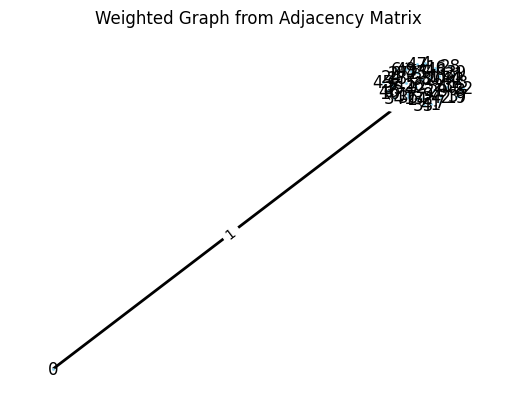

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

adj_matrix = server_matrix
G = nx.Graph()
num_nodes = adj_matrix.shape[0]  # Number of nodes in the graph
G.add_nodes_from(range(num_nodes))
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Only iterate over the upper triangle
        if adj_matrix[i][j] > 0:
            G.add_edge(i, j, weight=adj_matrix[i][j])

# Define the layout (e.g., spring_layout, shell_layout, etc.)
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw node labels (optional)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Display the graph
plt.title('Weighted Graph from Adjacency Matrix')
plt.axis('off')
plt.show()